In [1]:
# Step 1: Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Step 2: Give permission
!chmod 600 ~/.kaggle/kaggle.json


In [2]:
!kaggle datasets download -d khyeh0719/ptb-xl-dataset

Dataset URL: https://www.kaggle.com/datasets/khyeh0719/ptb-xl-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 1.71G/1.72G [00:24<00:00, 138MB/s]
100% 1.72G/1.72G [00:24<00:00, 74.3MB/s]


In [3]:
!unzip ptb-xl-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19338_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19342_hr.dat  
  inflating: ptb-xl-a-large-publicly-availabl

In [4]:
import pandas as pd

df = pd.read_csv("/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/scp_statements.csv")
df.head()


,Unnamed: 0,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
0,NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
1,NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
2,DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
3,LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
4,NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


In [6]:
import os, zipfile, json, pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

In [3]:
csv_path = "/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv"
df = pd.read_csv(csv_path)

# Quick overview
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
display(missing_pct.head(15).to_frame("missing %").style.format("{:.2f}"))

,missing %
electrodes_problems,99.86
infarction_stadium2,99.53
pacemaker,98.66
burst_noise,97.19
baseline_drift,92.64
extra_beats,91.05
static_noise,85.06
infarction_stadium1,74.24
height,68.02
weight,56.82


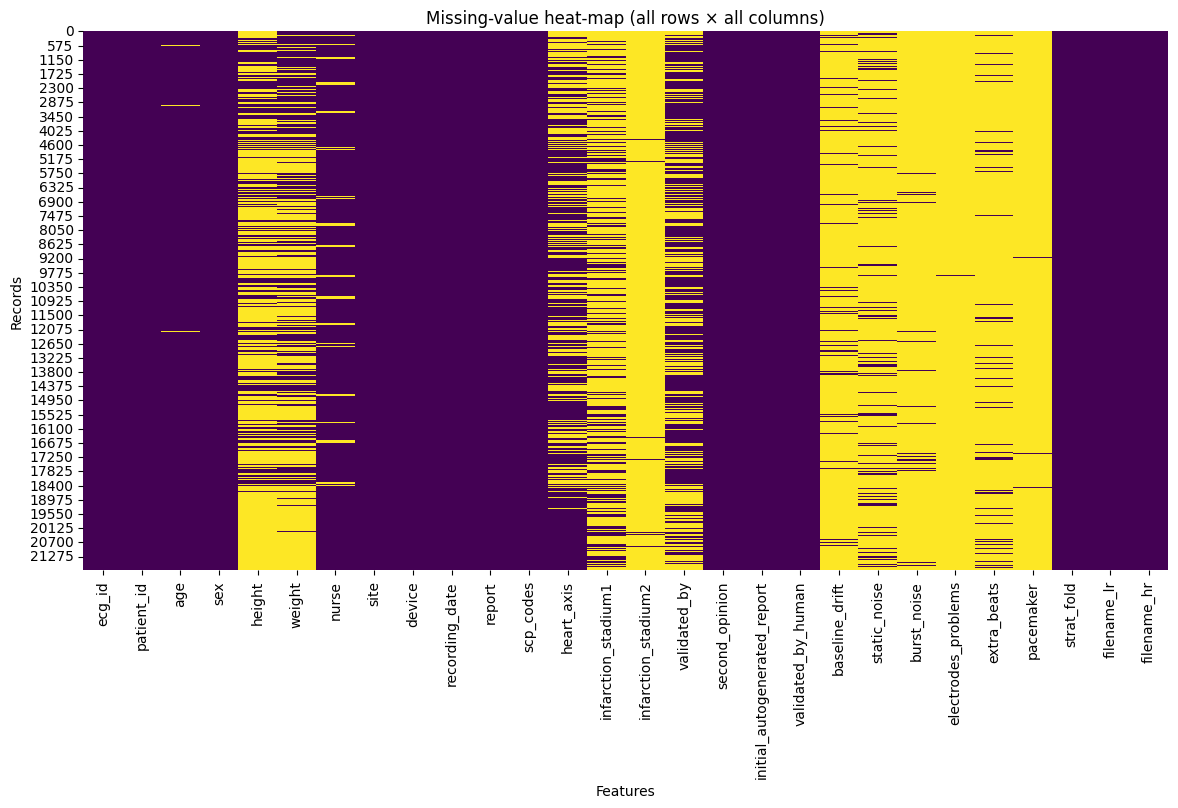

In [4]:
plt.figure(figsize=(14,7))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing-value heat-map (all rows × all columns)")
plt.xlabel("Features"); plt.ylabel("Records")
plt.show()

<Axes: >

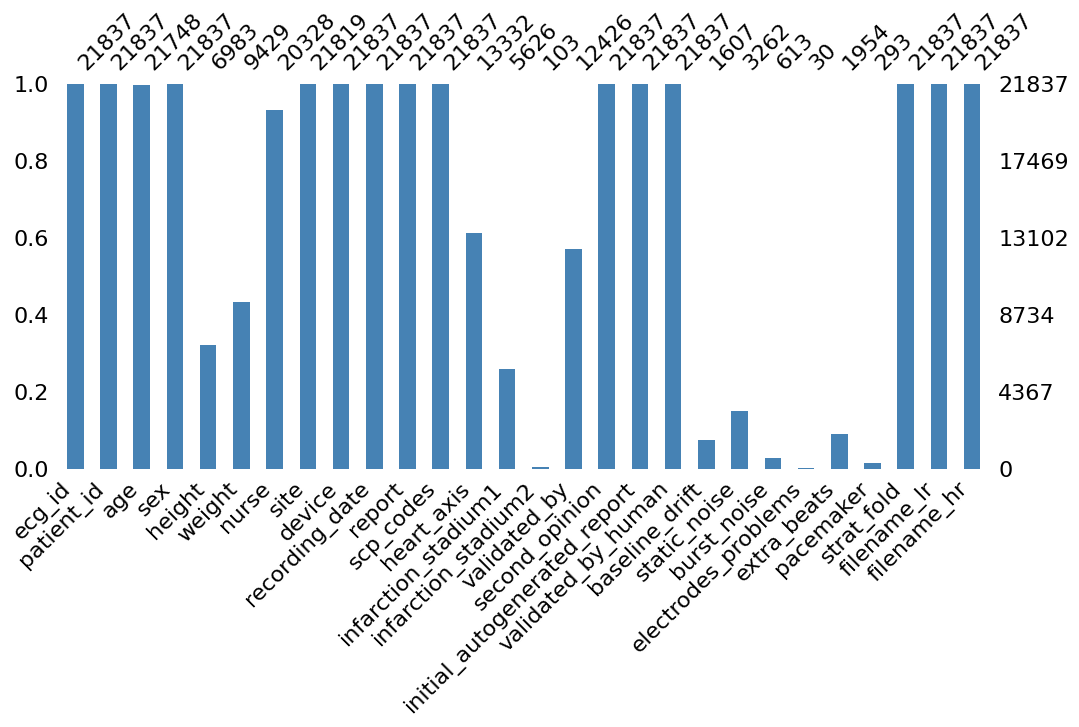

In [7]:
# Bar plot: absolute gaps per column
msno.bar(df, figsize=(12,5), color="steelblue")

<Axes: >

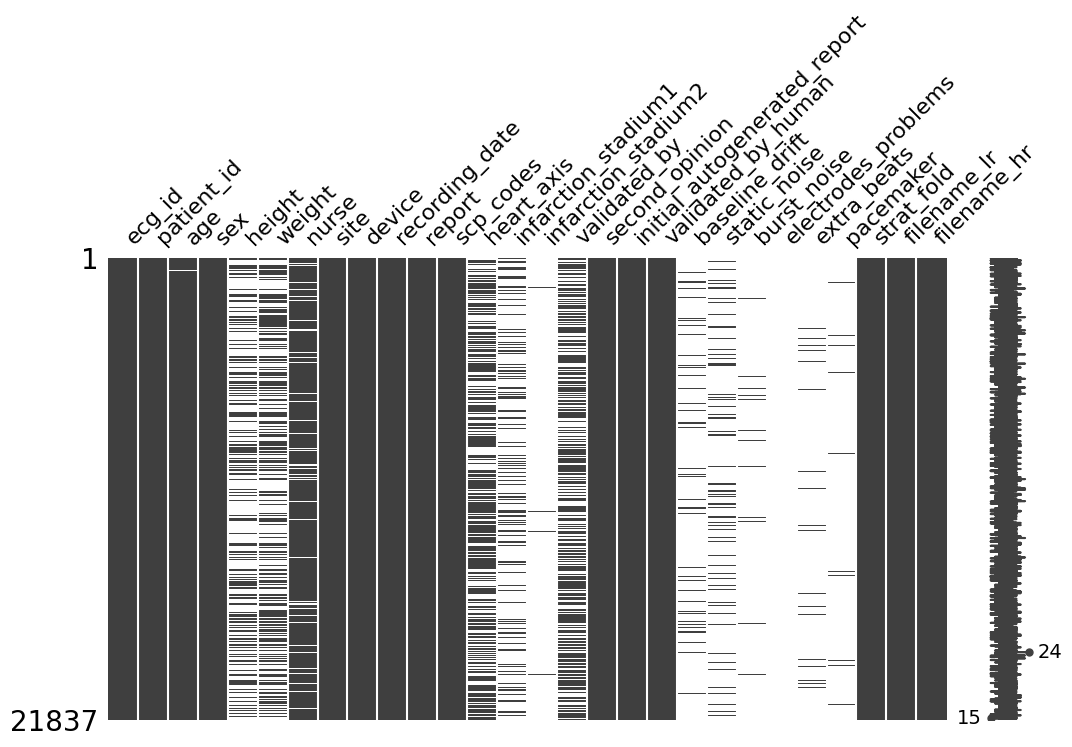

In [8]:
# Matrix plot: patterns over first 30k rows
msno.matrix(df.sample(min(len(df), 30000)), figsize=(12,6))

<Axes: >

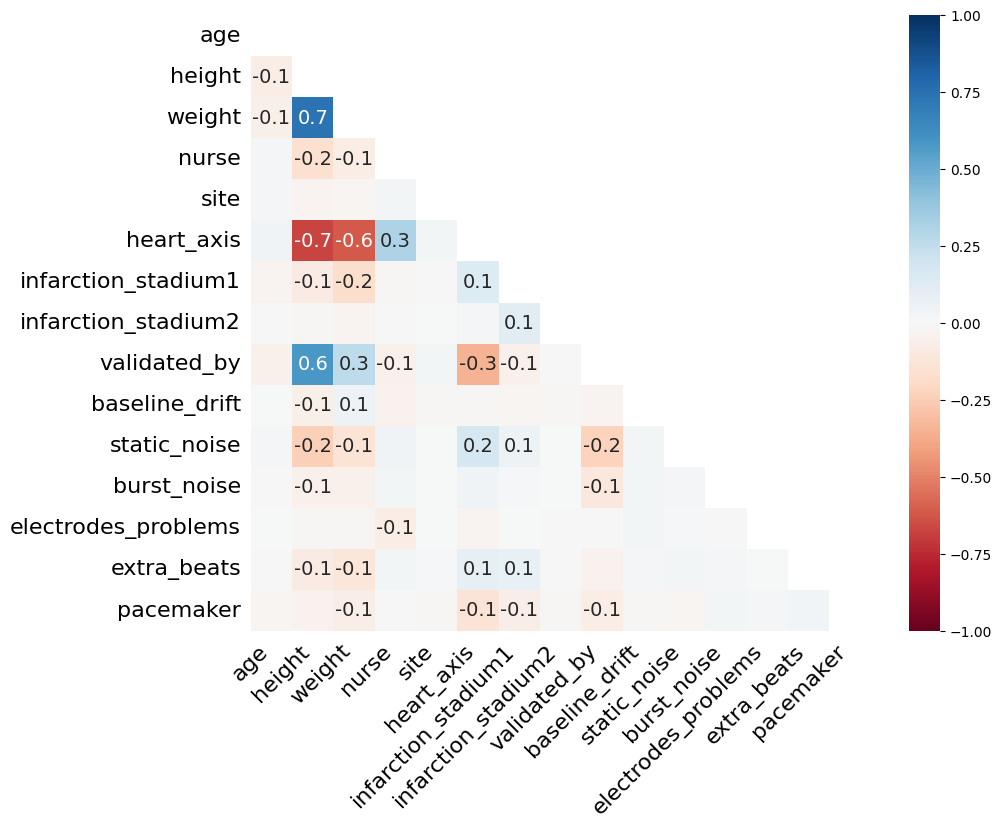

In [9]:
# Correlation heat-map: which columns miss together?
msno.heatmap(df, figsize=(10,8))

In [10]:
threshold = 0.50
cols_to_drop = missing_pct[missing_pct > threshold*100].index
df_reduced = df.drop(columns=cols_to_drop)
print(f"Dropped: {list(cols_to_drop)}")

Dropped: ['electrodes_problems', 'infarction_stadium2', 'pacemaker', 'burst_noise', 'baseline_drift', 'extra_beats', 'static_noise', 'infarction_stadium1', 'height', 'weight']


In [11]:
num_cols = df_reduced.select_dtypes(include=["int64","float64"]).columns
num_imputer = SimpleImputer(strategy="median")          # robust to outliers[37]
df_reduced[num_cols] = num_imputer.fit_transform(df_reduced[num_cols])

In [12]:
knn = KNNImputer(n_neighbors=5, weights="distance")
df_reduced[num_cols] = knn.fit_transform(df_reduced[num_cols])     # numeric only

Total missing values: 8505
Missing values per column:
heart_axis    8505
dtype: int64


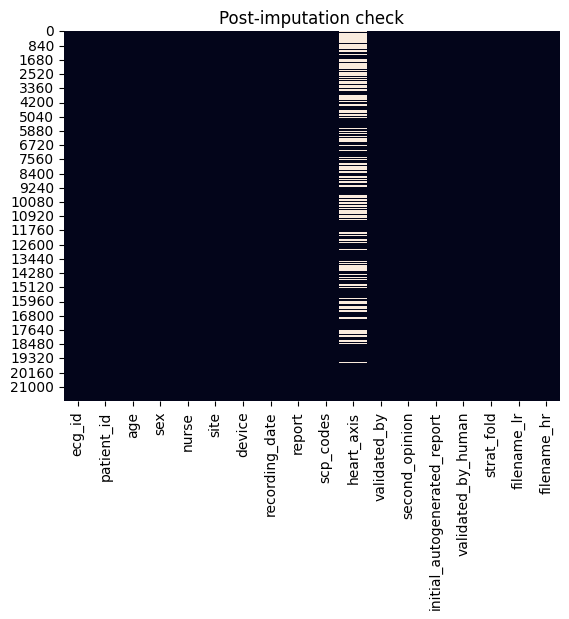

📁 Cleaned data saved to ptbxl_database_clean.csv


In [13]:
# Count total missing values
print("Total missing values:", df_reduced.isna().sum().sum())

# See which columns have missing values
print("Missing values per column:")
print(df_reduced.isna().sum()[df_reduced.isna().sum() > 0])


# Optional: final spot-check heat-map
sns.heatmap(df_reduced.isnull(), cbar=False)
plt.title("Post-imputation check"); plt.show()
df_reduced.to_csv("/content/ptbxl_database_clean.csv", index=False)
print("📁 Cleaned data saved to ptbxl_database_clean.csv")

In [14]:
import pandas as pd
import numpy as np
import ast
import wfdb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Load the cleaned metadata (after your missing data handling)
df_clean = pd.read_csv("/content/ptbxl_database_clean.csv")

# Load SCP statements for diagnostic mapping
scp_df = pd.read_csv("/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/scp_statements.csv", index_col=0)

# Extract hypertrophy labels from SCP codes
def extract_hypertrophy_labels(scp_codes_str):
    """Extract hypertrophy-related diagnoses from SCP codes"""
    if pd.isna(scp_codes_str):
        return {'has_hypertrophy': 0, 'lvh': 0, 'rvh': 0, 'lae': 0, 'rae': 0}

    scp_codes = ast.literal_eval(scp_codes_str)

    # Hypertrophy-related SCP codes from PTB-XL
    hyp_codes = {
        'LVH': 'lvh',           # Left ventricular hypertrophy
        'RVH': 'rvh',           # Right ventricular hypertrophy
        'LAO/LAE': 'lae',       # Left atrial enlargement
        'RAO/RAE': 'rae',       # Right atrial enlargement
        'SEHYP': 'sehyp'        # Septal hypertrophy
    }

    labels = {'has_hypertrophy': 0, 'lvh': 0, 'rvh': 0, 'lae': 0, 'rae': 0}

    for code, label in hyp_codes.items():
        if code in scp_codes:
            labels['has_hypertrophy'] = 1
            labels[label] = 1

    return labels

# Apply hypertrophy label extraction
hyp_labels = df_clean['scp_codes'].apply(extract_hypertrophy_labels)
hyp_df = pd.DataFrame(hyp_labels.tolist(), index=df_clean.index)
df_clean = pd.concat([df_clean, hyp_df], axis=1)

print(f"Hypertrophy cases: {df_clean['has_hypertrophy'].sum()}")
print(f"LVH cases: {df_clean['lvh'].sum()}")
print(f"Class distribution:\n{df_clean['has_hypertrophy'].value_counts()}")


Hypertrophy cases: 2655
LVH cases: 2137
Class distribution:
has_hypertrophy
0    19182
1     2655
Name: count, dtype: int64


In [17]:
def load_ecg_signals(df, sampling_rate=100, signal_length=1000):
    """Load ECG waveform data with preprocessing"""

    def load_raw_data(df, sampling_rate, path):
        if sampling_rate == 100:
            data = [wfdb.rdsamp(path + f) for f in df.filename_lr]
        else:
            data = [wfdb.rdsamp(path + f) for f in df.filename_hr]
        data = np.array([signal for signal, meta in data])
        return data

    # Load signals
    path = '/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
    X = load_raw_data(df, sampling_rate, path)

    # Ensure consistent shape
    if X.shape[1] != signal_length:
        # Pad or truncate to fixed length
        X_processed = np.zeros((X.shape[0], signal_length, X.shape[2]))
        for i in range(X.shape[0]):
            if X.shape[1] >= signal_length:
                X_processed[i] = X[i][:signal_length]
            else:
                X_processed[i][:X.shape[1]] = X[i]
                # Pad with zeros
        X = X_processed

    return X

# Load ECG signals
X_ecg = load_ecg_signals(df_clean)
print(f"ECG signal shape: {X_ecg.shape}")  # Should be (n_samples, 1000, 12)


ECG signal shape: (21837, 1000, 12)


In [18]:
def preprocess_ecg_signals(X, apply_filtering=True, normalize=True):
    """Advanced ECG signal preprocessing"""

    if apply_filtering:
        from scipy.signal import butter, filtfilt

        def bandpass_filter(data, lowcut=0.5, highcut=40, fs=100, order=4):
            """Apply bandpass filter to remove noise"""
            nyq = 0.5 * fs
            low = lowcut / nyq
            high = highcut / nyq
            b, a = butter(order, [low, high], btype='band')
            return filtfilt(b, a, data, axis=1)

        X_filtered = np.zeros_like(X)
        for i in range(X.shape[0]):
            X_filtered[i] = bandpass_filter(X[i].T).T
        X = X_filtered

    if normalize:
        # Per-sample normalization
        X_normalized = np.zeros_like(X)
        for i in range(X.shape[0]):
            for lead in range(X.shape[2]):
                signal = X[i, :, lead]
                if np.std(signal) > 0:  # Avoid division by zero
                    X_normalized[i, :, lead] = (signal - np.mean(signal)) / np.std(signal)
                else:
                    X_normalized[i, :, lead] = signal
        X = X_normalized

    return X

# Apply preprocessing
X_processed = preprocess_ecg_signals(X_ecg)
print(f"Processed ECG shape: {X_processed.shape}")

Processed ECG shape: (21837, 1000, 12)


In [19]:
def build_cnn_lstm_model(input_shape, num_classes=1):
    """Build CNN-LSTM hybrid model for ECG classification"""

    model = models.Sequential([
        # Convolutional layers for feature extraction
        layers.Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(64, kernel_size=5, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(128, kernel_size=3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),

        # LSTM layers for temporal dependencies
        layers.LSTM(128, return_sequences=True, dropout=0.3),
        layers.LSTM(64, dropout=0.3),

        # Dense layers for classification
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='sigmoid')
    ])

    return model

# Create model
input_shape = (X_processed.shape[1], X_processed.shape[2])  # (1000, 12)
model = build_cnn_lstm_model(input_shape)

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 996, 32)        │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 996, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 498, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 494, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 494, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 247, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 245, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 245, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 122, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 122, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,489 (919.88 KB)

 Trainable params: 235,041 (918.13 KB)

 Non-trainable params: 448 (1.75 KB)

In [20]:
# Use PTB-XL recommended train/test split
test_fold = 10
train_idx = df_clean['strat_fold'] != test_fold
test_idx = df_clean['strat_fold'] == test_fold

# Split data
X_train = X_processed[train_idx]
X_test = X_processed[test_idx]
y_train = df_clean[train_idx]['has_hypertrophy'].values
y_test = df_clean[test_idx]['has_hypertrophy'].values

# Further split train into train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Class distribution in training: {np.bincount(y_train)}")

Training set: 15707 samples
Validation set: 3927 samples
Test set: 2203 samples
Class distribution in training: [13793  1914]


In [21]:
# Compute class weights for imbalanced dataset
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print(f"Class weights: {class_weight_dict}")

Class weights: {np.int64(0): np.float64(0.5693830203726528), np.int64(1): np.float64(4.103187042842215)}


In [22]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    )
]

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
491/491 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6891 - loss: 0.6406 - precision: 0.2214 - recall: 0.5944 - val_accuracy: 0.7899 - val_loss: 0.4344 - val_precision: 0.3066 - val_recall: 0.5753 - learning_rate: 0.0010
Epoch 2/100
491/491 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.7179 - loss: 0.5746 - precision: 0.2576 - recall: 0.6966 - val_accuracy: 0.6595 - val_loss: 0.6487 - val_precision: 0.2354 - val_recall: 0.7992 - learning_rate: 0.0010
Epoch 3/100
491/491 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7233 - loss: 0.5537 - precision: 0.2749 - recall: 0.7387 - val_accuracy: 0.6713 - val_loss: 0.5663 - val_precision: 0.2422 - val_recall: 0.7992 - learning_rate: 0.0010
Epoch 4/100
491/491 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7225 - loss: 0.5369 - precision: 0.2643 - recall: 0.7498 - val_accuracy: 0.7171 - val_loss: 0.5581 - val_precision: 0.2671 - val_recall: 0.7594 - learning_rate: 0.0010
Epoch 5/100
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/st

In [23]:
def build_risk_prediction_model(input_shape):
    """Build model to predict future hypertension risk"""

    # Feature extraction backbone
    inputs = layers.Input(shape=input_shape)

    # CNN feature extractor
    x = layers.Conv1D(64, 7, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(3)(x)

    x = layers.Conv1D(128, 5, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(3)(x)

    x = layers.Conv1D(256, 3, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Risk score head
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Output continuous risk score
    risk_score = layers.Dense(1, activation='linear', name='risk_score')(x)

    return models.Model(inputs, risk_score)

# Build risk prediction model
risk_model = build_risk_prediction_model(input_shape)
risk_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

In [24]:
def build_multi_task_model(input_shape):
    """Build multi-task model for both hypertrophy detection and risk prediction"""

    # Shared feature extraction
    inputs = layers.Input(shape=input_shape)

    # Shared CNN backbone
    x = layers.Conv1D(64, 7, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(3)(x)

    x = layers.Conv1D(128, 5, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(3)(x)

    x = layers.Conv1D(256, 3, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # LSTM for temporal features
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(64)(x)

    # Shared dense layers
    shared_dense = layers.Dense(128, activation='relu')(x)
    shared_dense = layers.Dropout(0.5)(shared_dense)

    # Task-specific heads

    # Hypertrophy classification head
    hyp_head = layers.Dense(64, activation='relu')(shared_dense)
    hyp_head = layers.Dropout(0.3)(hyp_head)
    hypertrophy_output = layers.Dense(1, activation='sigmoid', name='hypertrophy')(hyp_head)

    # Risk prediction head
    risk_head = layers.Dense(64, activation='relu')(shared_dense)
    risk_head = layers.Dropout(0.3)(risk_head)
    risk_output = layers.Dense(1, activation='linear', name='risk_score')(risk_head)

    return models.Model(inputs, [hypertrophy_output, risk_output])

# Build multi-task model
multi_task_model = build_multi_task_model(input_shape)
multi_task_model.compile(
    optimizer='adam',
    loss={
        'hypertrophy': 'binary_crossentropy',
        'risk_score': 'mse'
    },
    loss_weights={
        'hypertrophy': 1.0,
        'risk_score': 0.5
    },
    metrics={
        'hypertrophy': ['accuracy', 'precision', 'recall'],
        'risk_score': ['mae']
    }
)

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step

CNN-LSTM Hypertrophy Detection Evaluation:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1940
           1       0.34      0.63      0.44       263

    accuracy                           0.81      2203
   macro avg       0.64      0.73      0.66      2203
weighted avg       0.87      0.81      0.83      2203

AUC-ROC: 0.8041


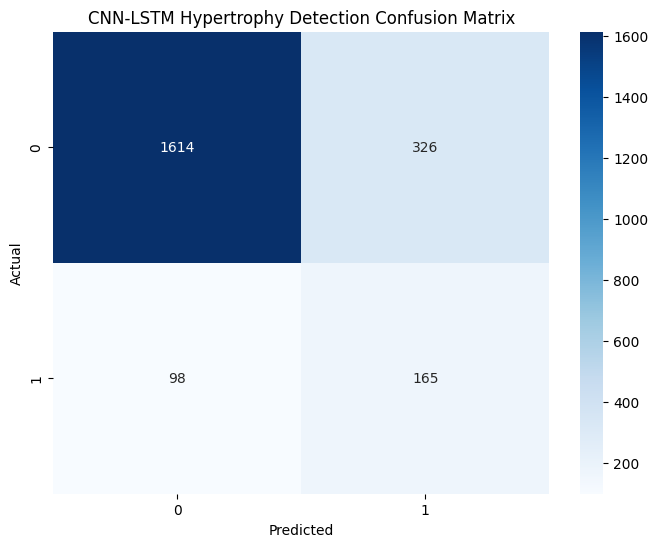

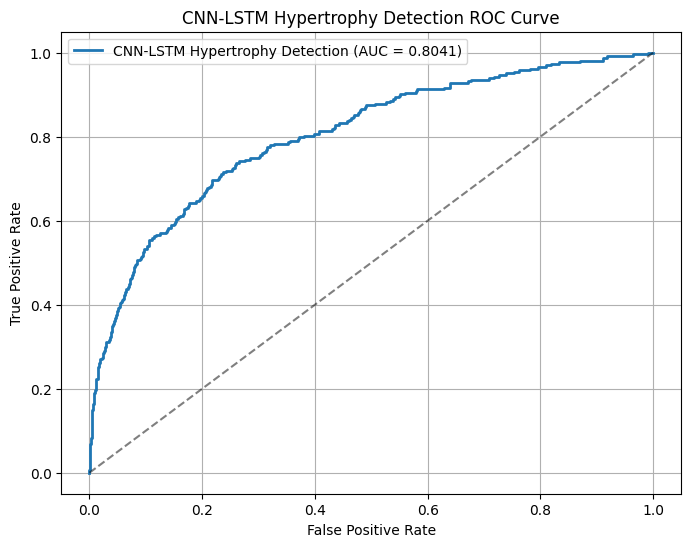

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Comprehensive model evaluation"""

    # Predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Metrics
    print(f"\n{model_name} Evaluation:")
    print("="*50)

    # Classification metrics
    print(classification_report(y_test, y_pred))

    # AUC-ROC
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC-ROC: {auc_score:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'auc_score': auc_score
    }

# Evaluate primary model
results = evaluate_model(model, X_test, y_test, "CNN-LSTM Hypertrophy Detection")

In [26]:
# Save trained model
model.save('/content/hypertrophy_detection_model.h5')

# Save preprocessing parameters
preprocessing_params = {
    'signal_length': 1000,
    'sampling_rate': 100,
    'apply_filtering': True,
    'normalize': True,
    'class_weights': class_weight_dict
}

import pickle
with open('/content/preprocessing_params.pkl', 'wb') as f:
    pickle.dump(preprocessing_params, f)

# Load model for inference
loaded_model = tf.keras.models.load_model('/content/hypertrophy_detection_model.h5')


In [27]:
def predict_hypertension_risk(ecg_signal, model, preprocessing_params):
    """Clinical decision support function for hypertension prediction"""

    # Preprocess signal
    ecg_processed = preprocess_ecg_signals(
        ecg_signal.reshape(1, -1, 12),
        apply_filtering=preprocessing_params['apply_filtering'],
        normalize=preprocessing_params['normalize']
    )

    # Predict
    probability = model.predict(ecg_processed)[0, 0]
    risk_category = "High" if probability > 0.5 else "Low"

    # Generate report
    report = {
        'hypertrophy_probability': float(probability),
        'risk_category': risk_category,
        'recommendation': get_clinical_recommendation(probability)
    }

    return report

def get_clinical_recommendation(probability):
    """Generate clinical recommendations based on prediction"""

    if probability > 0.8:
        return "High risk - Immediate echocardiography recommended"
    elif probability > 0.5:
        return "Moderate risk - Consider echocardiography and clinical correlation"
    else:
        return "Low risk - Routine follow-up appropriate"

# Example usage
sample_ecg = X_test[0]  # Shape: (1000, 12)
risk_assessment = predict_hypertension_risk(sample_ecg, model, preprocessing_params)
print(f"Risk Assessment: {risk_assessment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Risk Assessment: {'hypertrophy_probability': 0.0076172444969415665, 'risk_category': 'Low', 'recommendation': 'Low risk - Routine follow-up appropriate'}
